In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# load featurized data
train_sf_df = pd.read_csv(filepath_or_buffer='data/train_data_features_fix.csv')
test_sf_df = pd.read_csv(filepath_or_buffer='data/test_data_features.csv')
df = pd.read_csv(filepath_or_buffer='data/train.csv')

In [3]:
train_sf_df.head()

longitude   latitude  year  month  day  hour  minute  Friday  Monday  \
0 -122.425892  37.774599  2015      5   13    23      53       0       0   
1 -122.425892  37.774599  2015      5   13    23      53       0       0   
2 -122.424363  37.800414  2015      5   13    23      33       0       0   
3 -122.426995  37.800873  2015      5   13    23      30       0       0   
4 -122.438738  37.771541  2015      5   13    23      30       0       0   

   Saturday  ...  1178.1  1180.1  1392.1    1466.1  1500.1  1550.1  1582.1  \
0         0  ...     0.0     0.0     0.0  0.000000     0.0     0.0     0.0   
1         0  ...     0.0     0.0     0.0  0.000000     0.0     0.0     0.0   
2         0  ...     0.0     0.0     0.0  0.000000     0.0     0.0     0.0   
3         0  ...     0.0     0.0     0.0  0.158147     0.0     0.0     0.0   
4         0  ...     0.0     0.0     0.0  0.158047     0.0     0.0     0.0   

   1817.1    1854.1  1971.1  
0     0.0  0.260309     0.0  
1     0.0  0.260309     0.0  
2     0.0  0.130387     0.0  
3     0.0  0.144994     0.0  
4     0.0  0.144902     0.0  

[5 rows x 130 columns]

In [4]:
train_sf_df['category'] = df['Category']
test_sf_df = test_sf_df.drop(columns=['id'])

### Data Preprocessing

In [5]:
data = train_sf_df
X = data.drop(columns=['category'])
y = data['category']

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
def preprocess_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

In [8]:
X_norm = preprocess_data(X=X)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify=y, test_size=0.20)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

In [11]:
print("Training data shape : ", X_train.shape)
print("Validation data shape : ", X_valid.shape)
print("Test data shape : ", X_test.shape)

Training data shape :  (561951, 130)
Validation data shape :  (140488, 130)
Test data shape :  (175610, 130)


In [12]:
labels = [
    'ARSON',
    'ASSAULT',
    'BAD CHECKS',
    'BRIBERY',
    'BURGLARY',
    'DISORDERLY CONDUCT',
    'DRIVING UNDER THE INFLUENCE',
    'DRUG/NARCOTIC',
    'DRUNKENNESS',
    'EMBEZZLEMENT',
    'EXTORTION',
    'FAMILY OFFENSES',
    'FORGERY/COUNTERFEITING',
    'FRAUD',
    'GAMBLING',
    'KIDNAPPING',
    'LARCENY/THEFT',
    'LIQUOR LAWS',
    'LOITERING',
    'MISSING PERSON',
    'NON-CRIMINAL',
    'OTHER OFFENSES',
    'PORNOGRAPHY/OBSCENE MAT',
    'PROSTITUTION',
    'RECOVERED VEHICLE',
    'ROBBERY',
    'RUNAWAY',
    'SECONDARY CODES',
    'SEX OFFENSES FORCIBLE',
    'SEX OFFENSES NON FORCIBLE',
    'STOLEN PROPERTY',
    'SUICIDE',
    'SUSPICIOUS OCC',
    'TREA',
    'TRESPASS',
    'VANDALISM',
    'VEHICLE THEFT',
    'WARRANTS',
    'WEAPON LAWS'
]

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
def plot_heatmap(matrix, title, labels, cmap='YlGnBu'):
    plt.figure(figsize=(25, 20))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return None


def plot_confusion_matrix(y_actuals, y_preds, labels=labels):
    # confusion matrix
    cmat = confusion_matrix(y_true=y_actuals, y_pred=y_preds)
    # precision matrix
    pmat = cmat / cmat.sum(axis=0)
    # recall matrix
    rmat = cmat / cmat.sum(axis=1)
    # class labels

    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)

    return None

## Classifiers

In [15]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn import metrics

In [16]:
def log_reg_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = 'models/'
    model_name = 'log_reg_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = LogisticRegression(penalty='l2', C=30, n_jobs=-1)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)

        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)

    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Training Log Loss: 2.4904732415026634
Validation Log Loss: 2.491162938373936
Testing Log Loss: 2.493493321937447


C:\Users\Monster\AppData\Local\Temp\ipykernel_19632\91422066.py:16: RuntimeWarning: invalid value encountered in divide
  pmat = cmat / cmat.sum(axis=0)


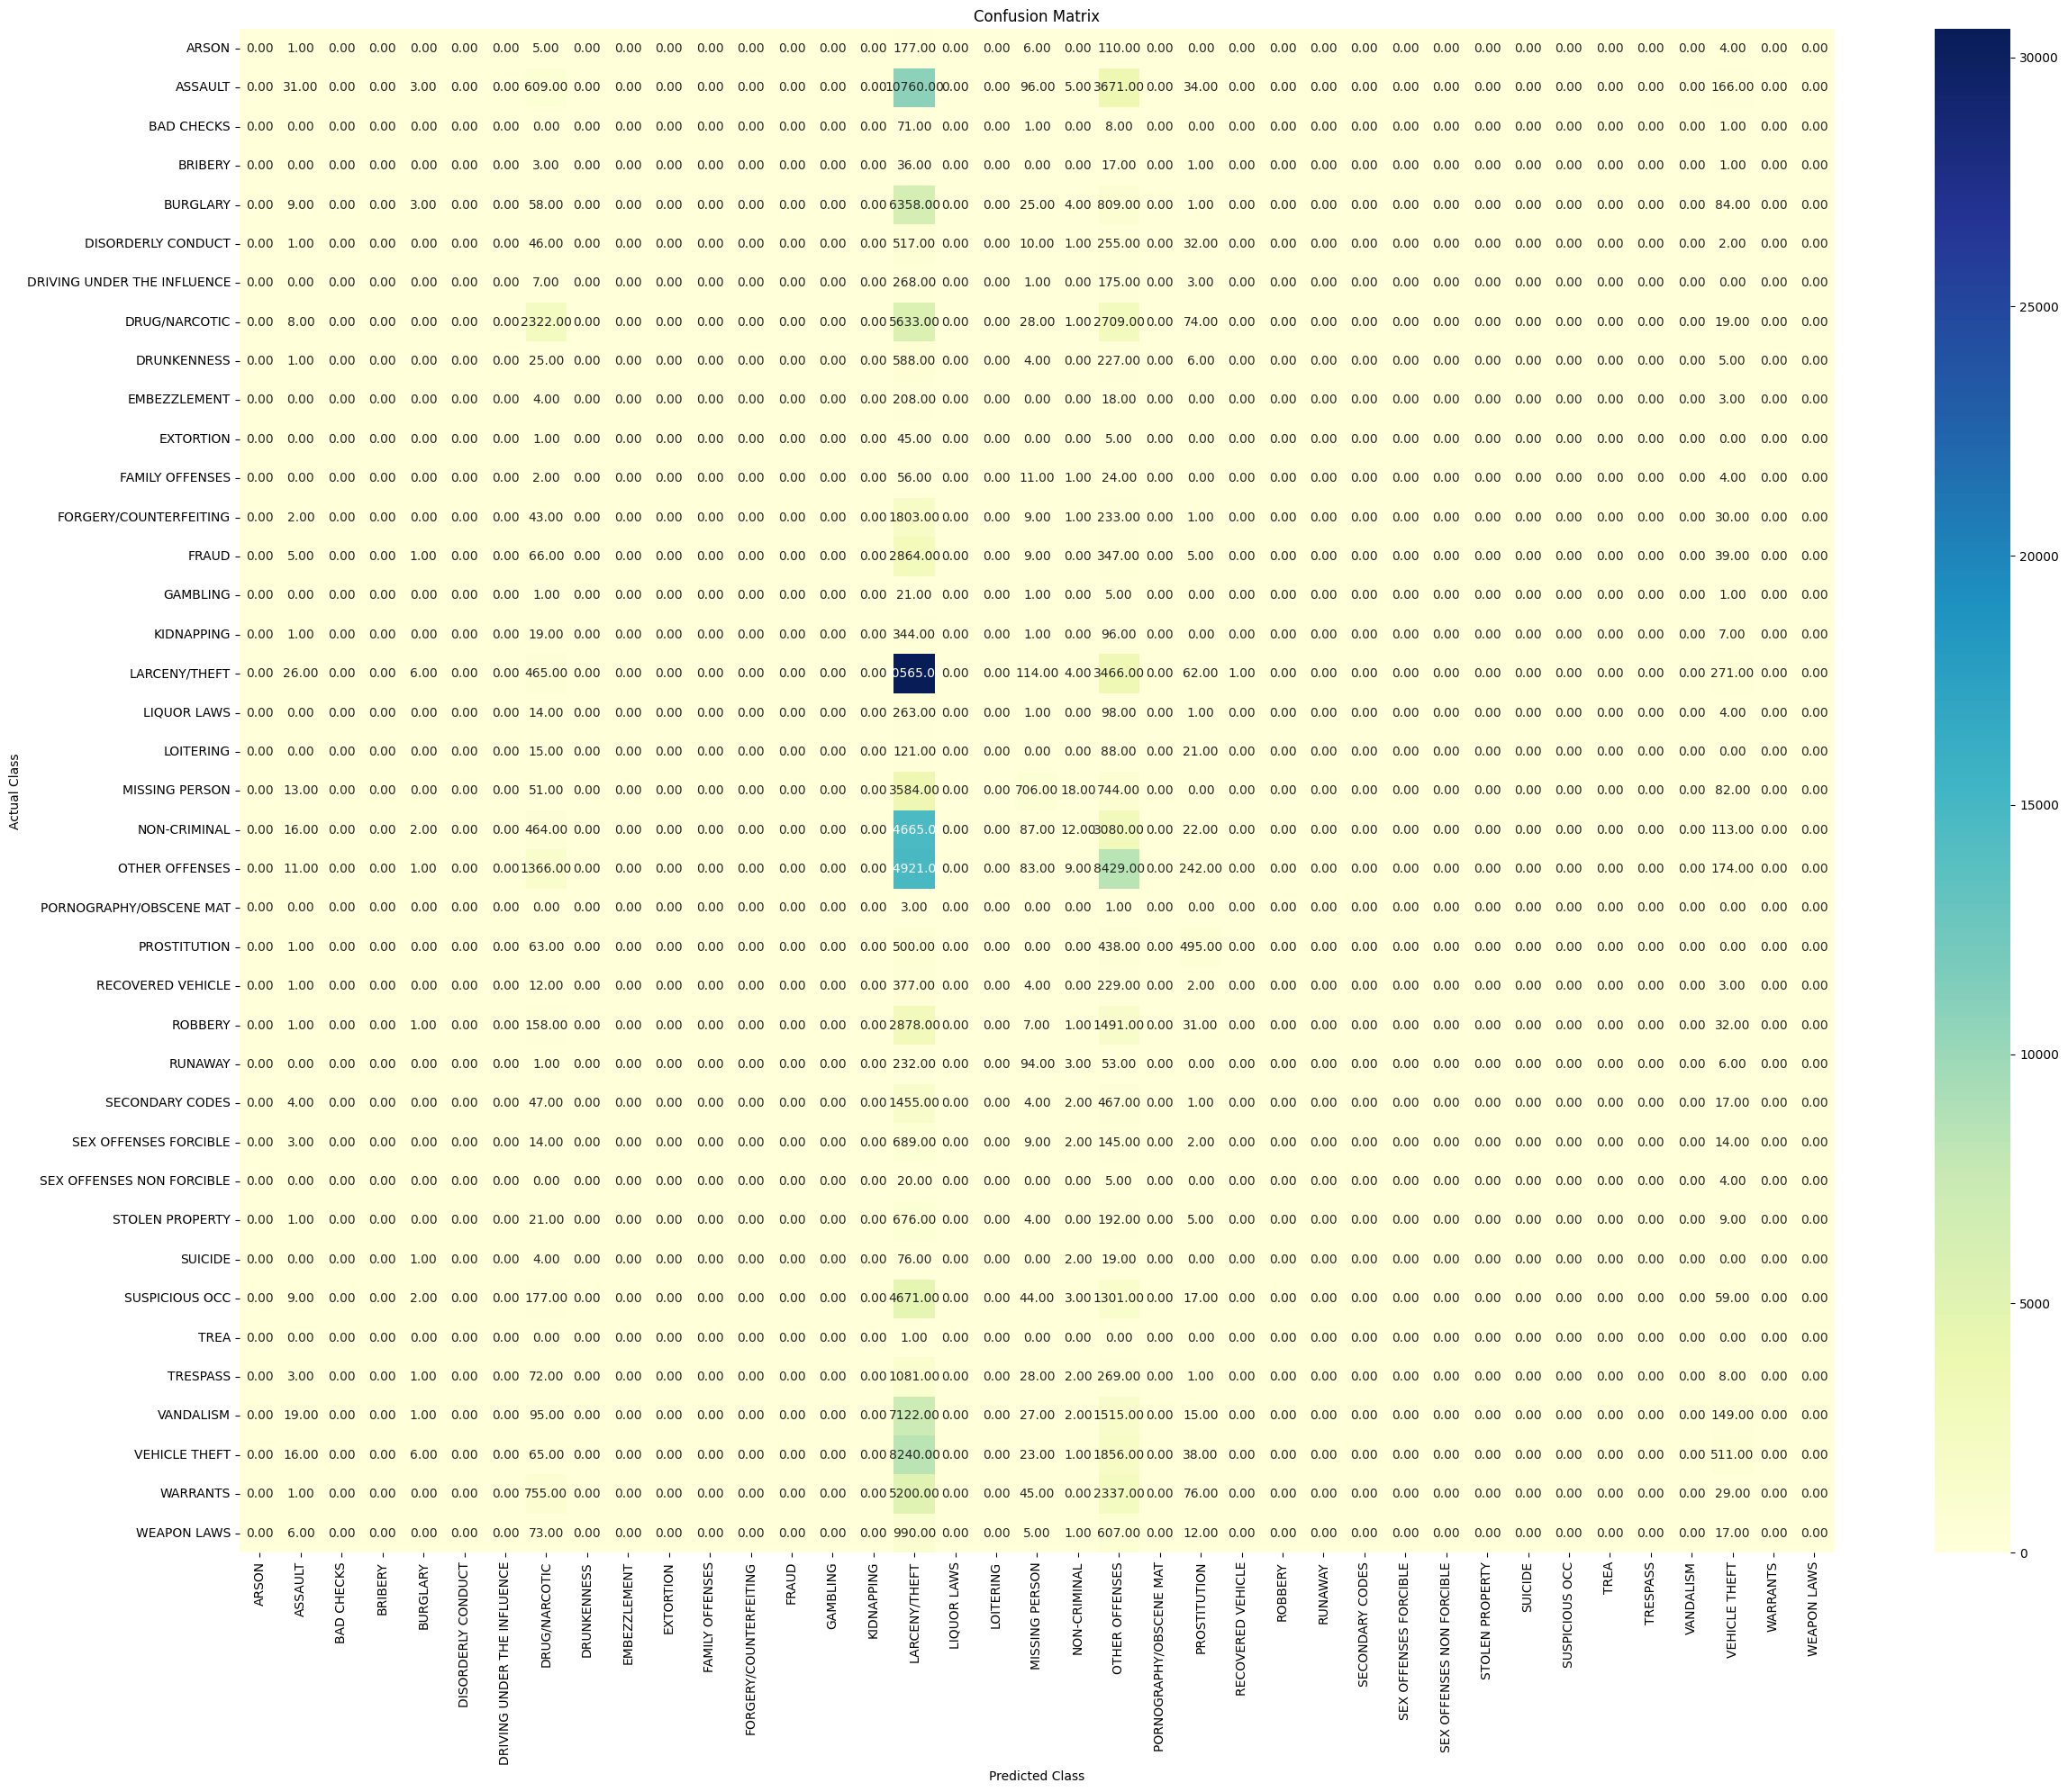

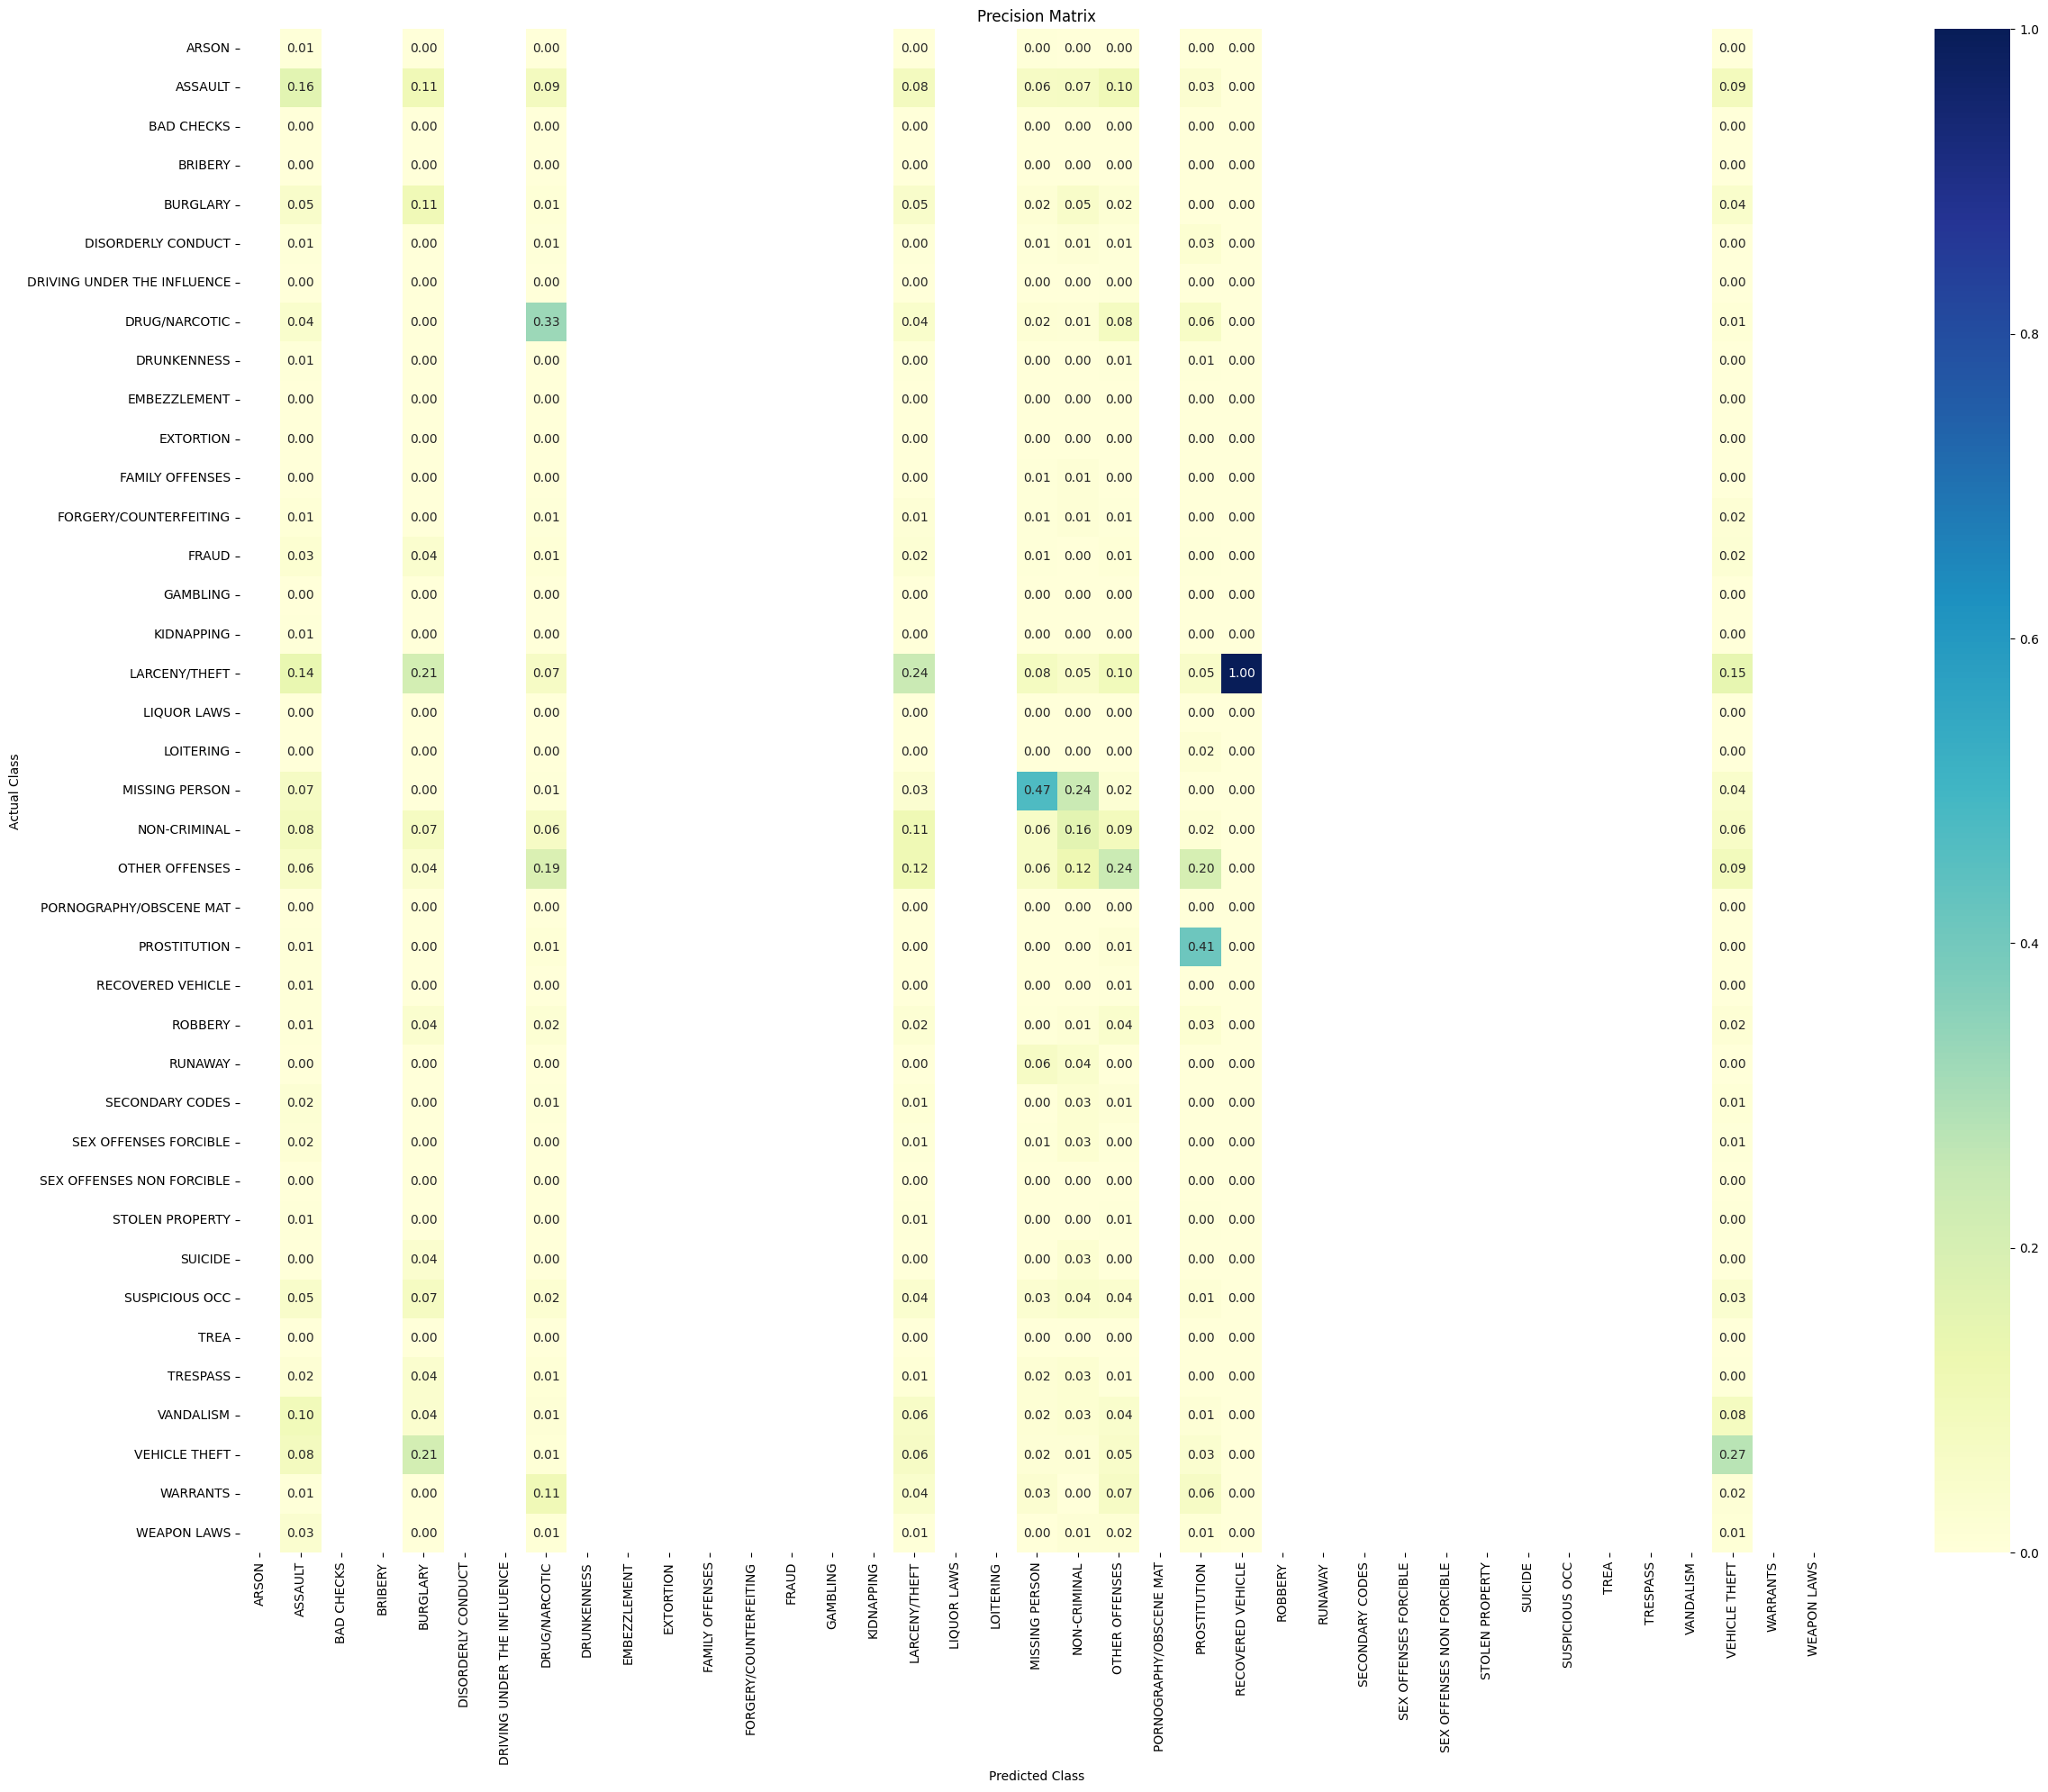

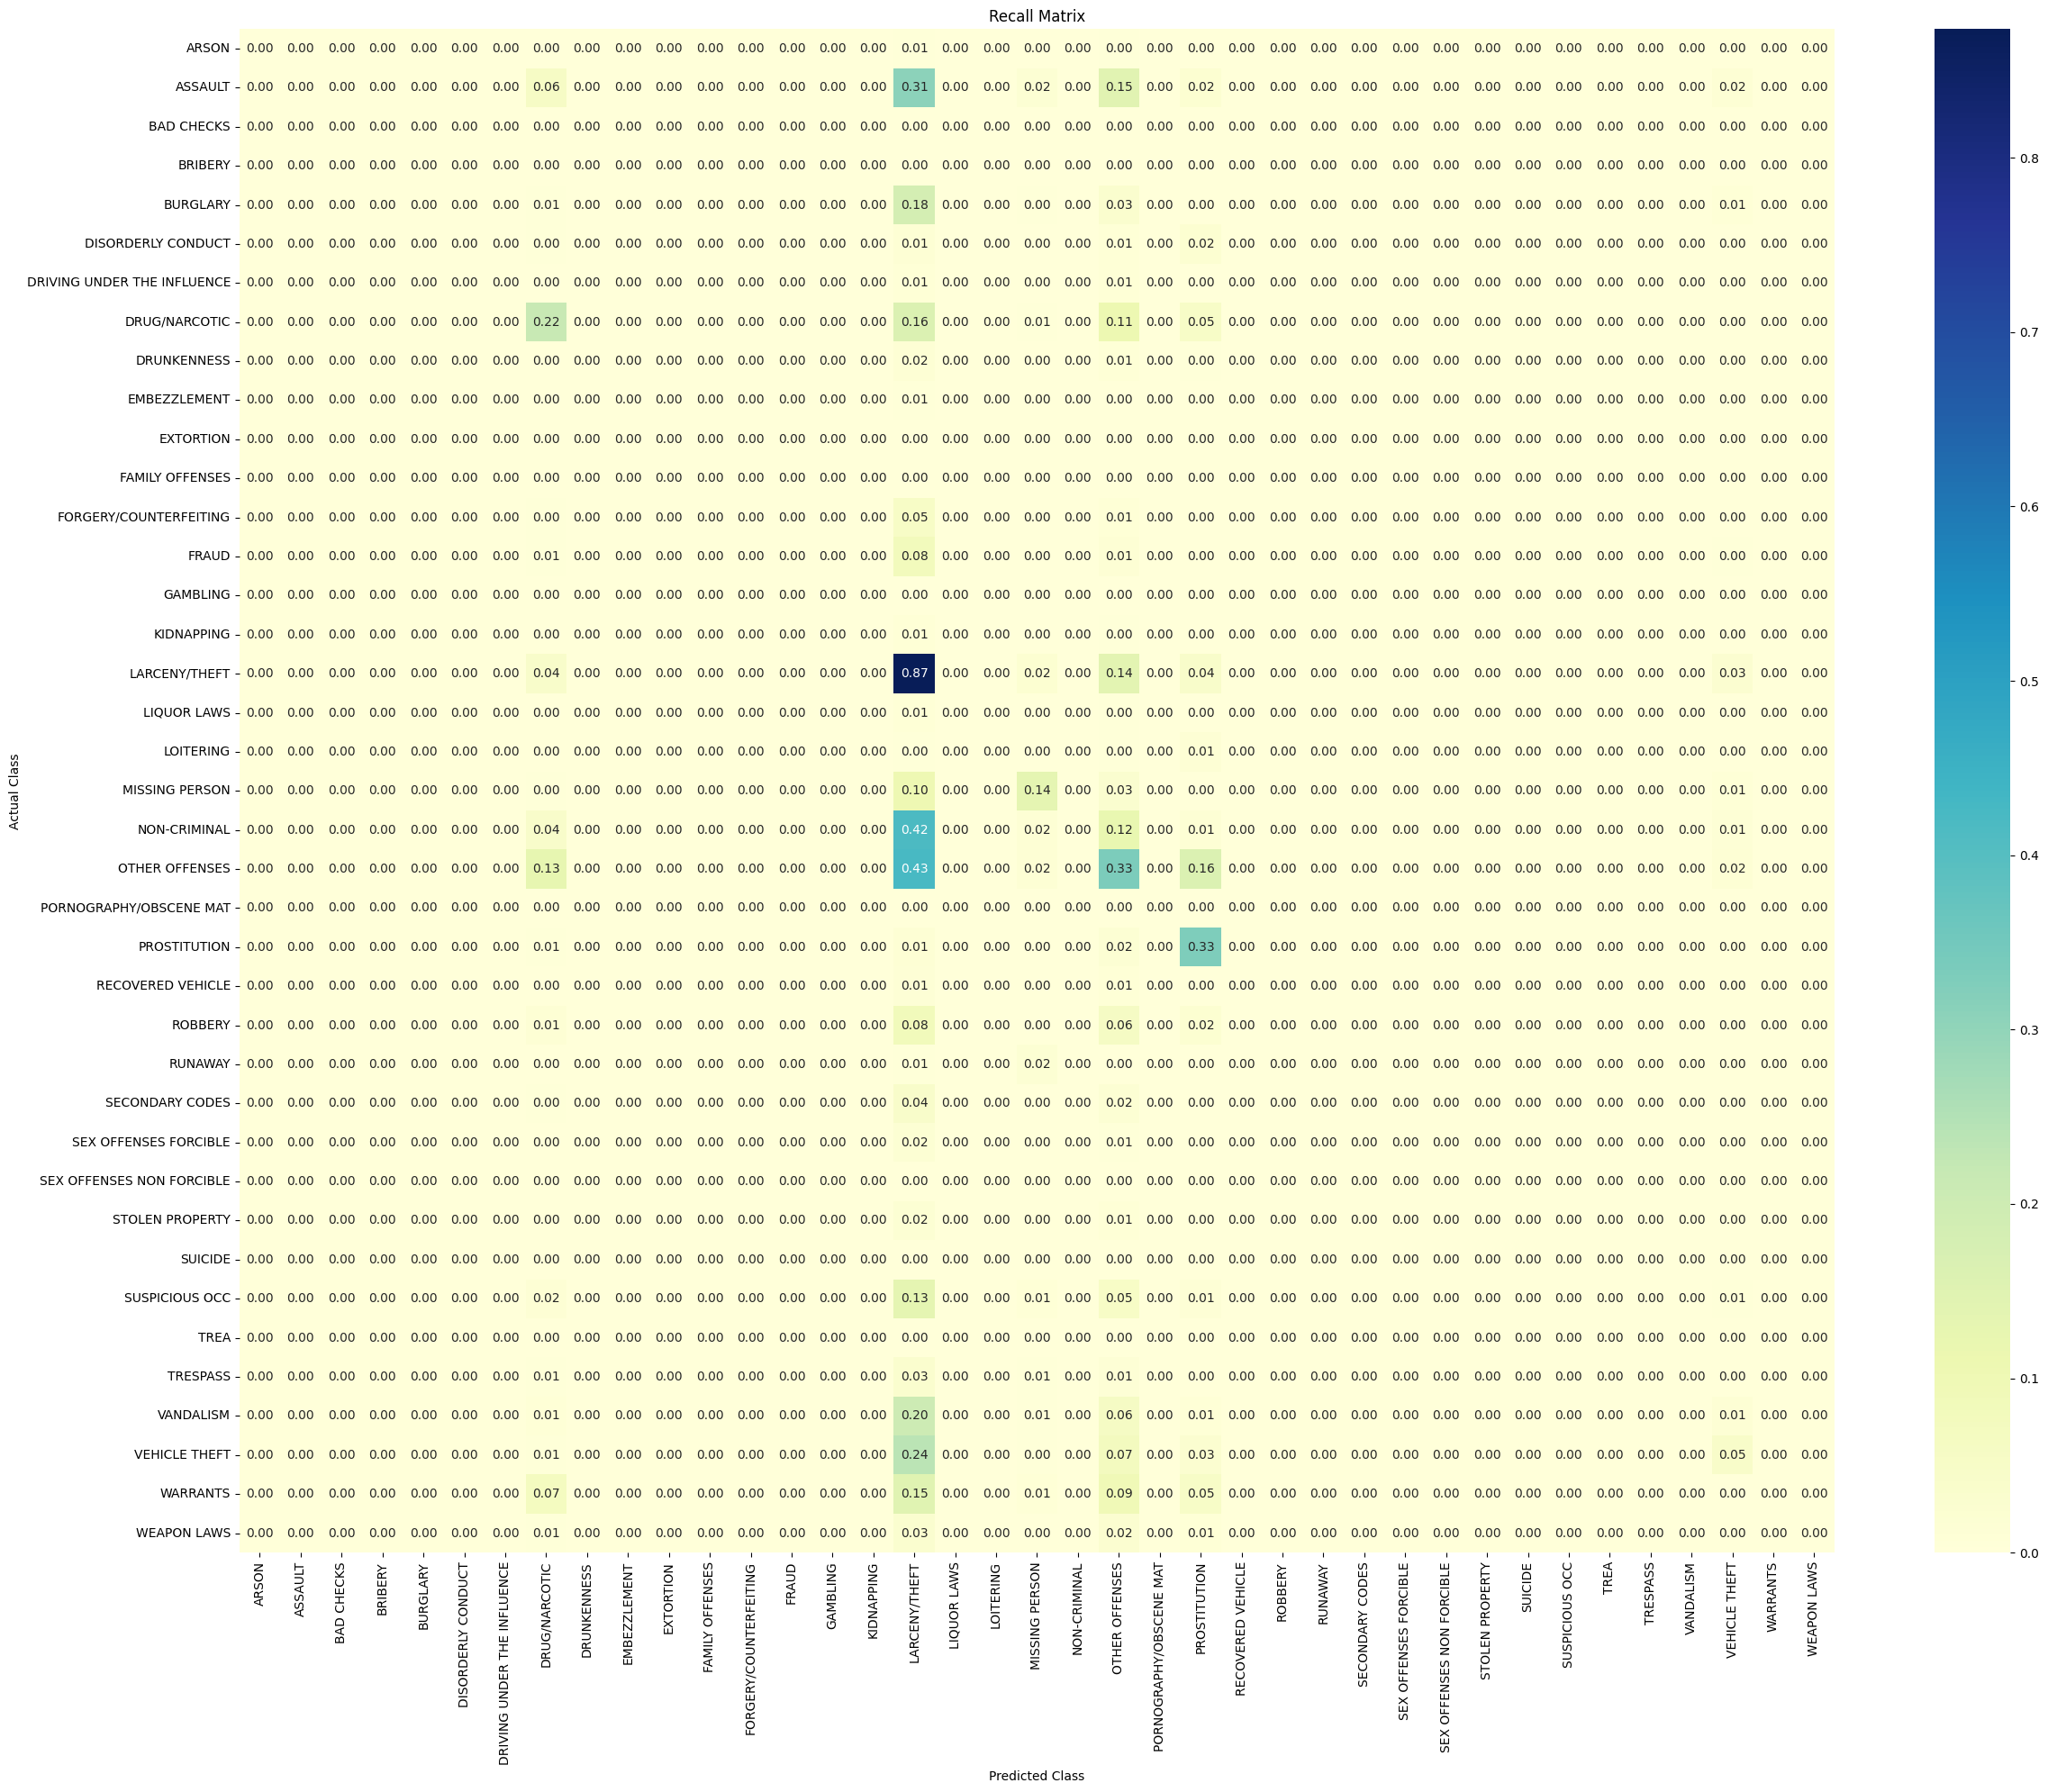

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.16      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.11      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.33      0.22      0.26     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
lr_train_loss, lr_valid_loss, lr_test_loss = log_reg_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
def decision_tree_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = 'models/'
    model_name = 'decision_tree_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)

        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)

    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Training Log Loss: 2.3184377035060875
Validation Log Loss: 2.3771070864676846
Testing Log Loss: 2.37866795645062


C:\Users\Monster\AppData\Local\Temp\ipykernel_19632\91422066.py:16: RuntimeWarning: invalid value encountered in divide
  pmat = cmat / cmat.sum(axis=0)


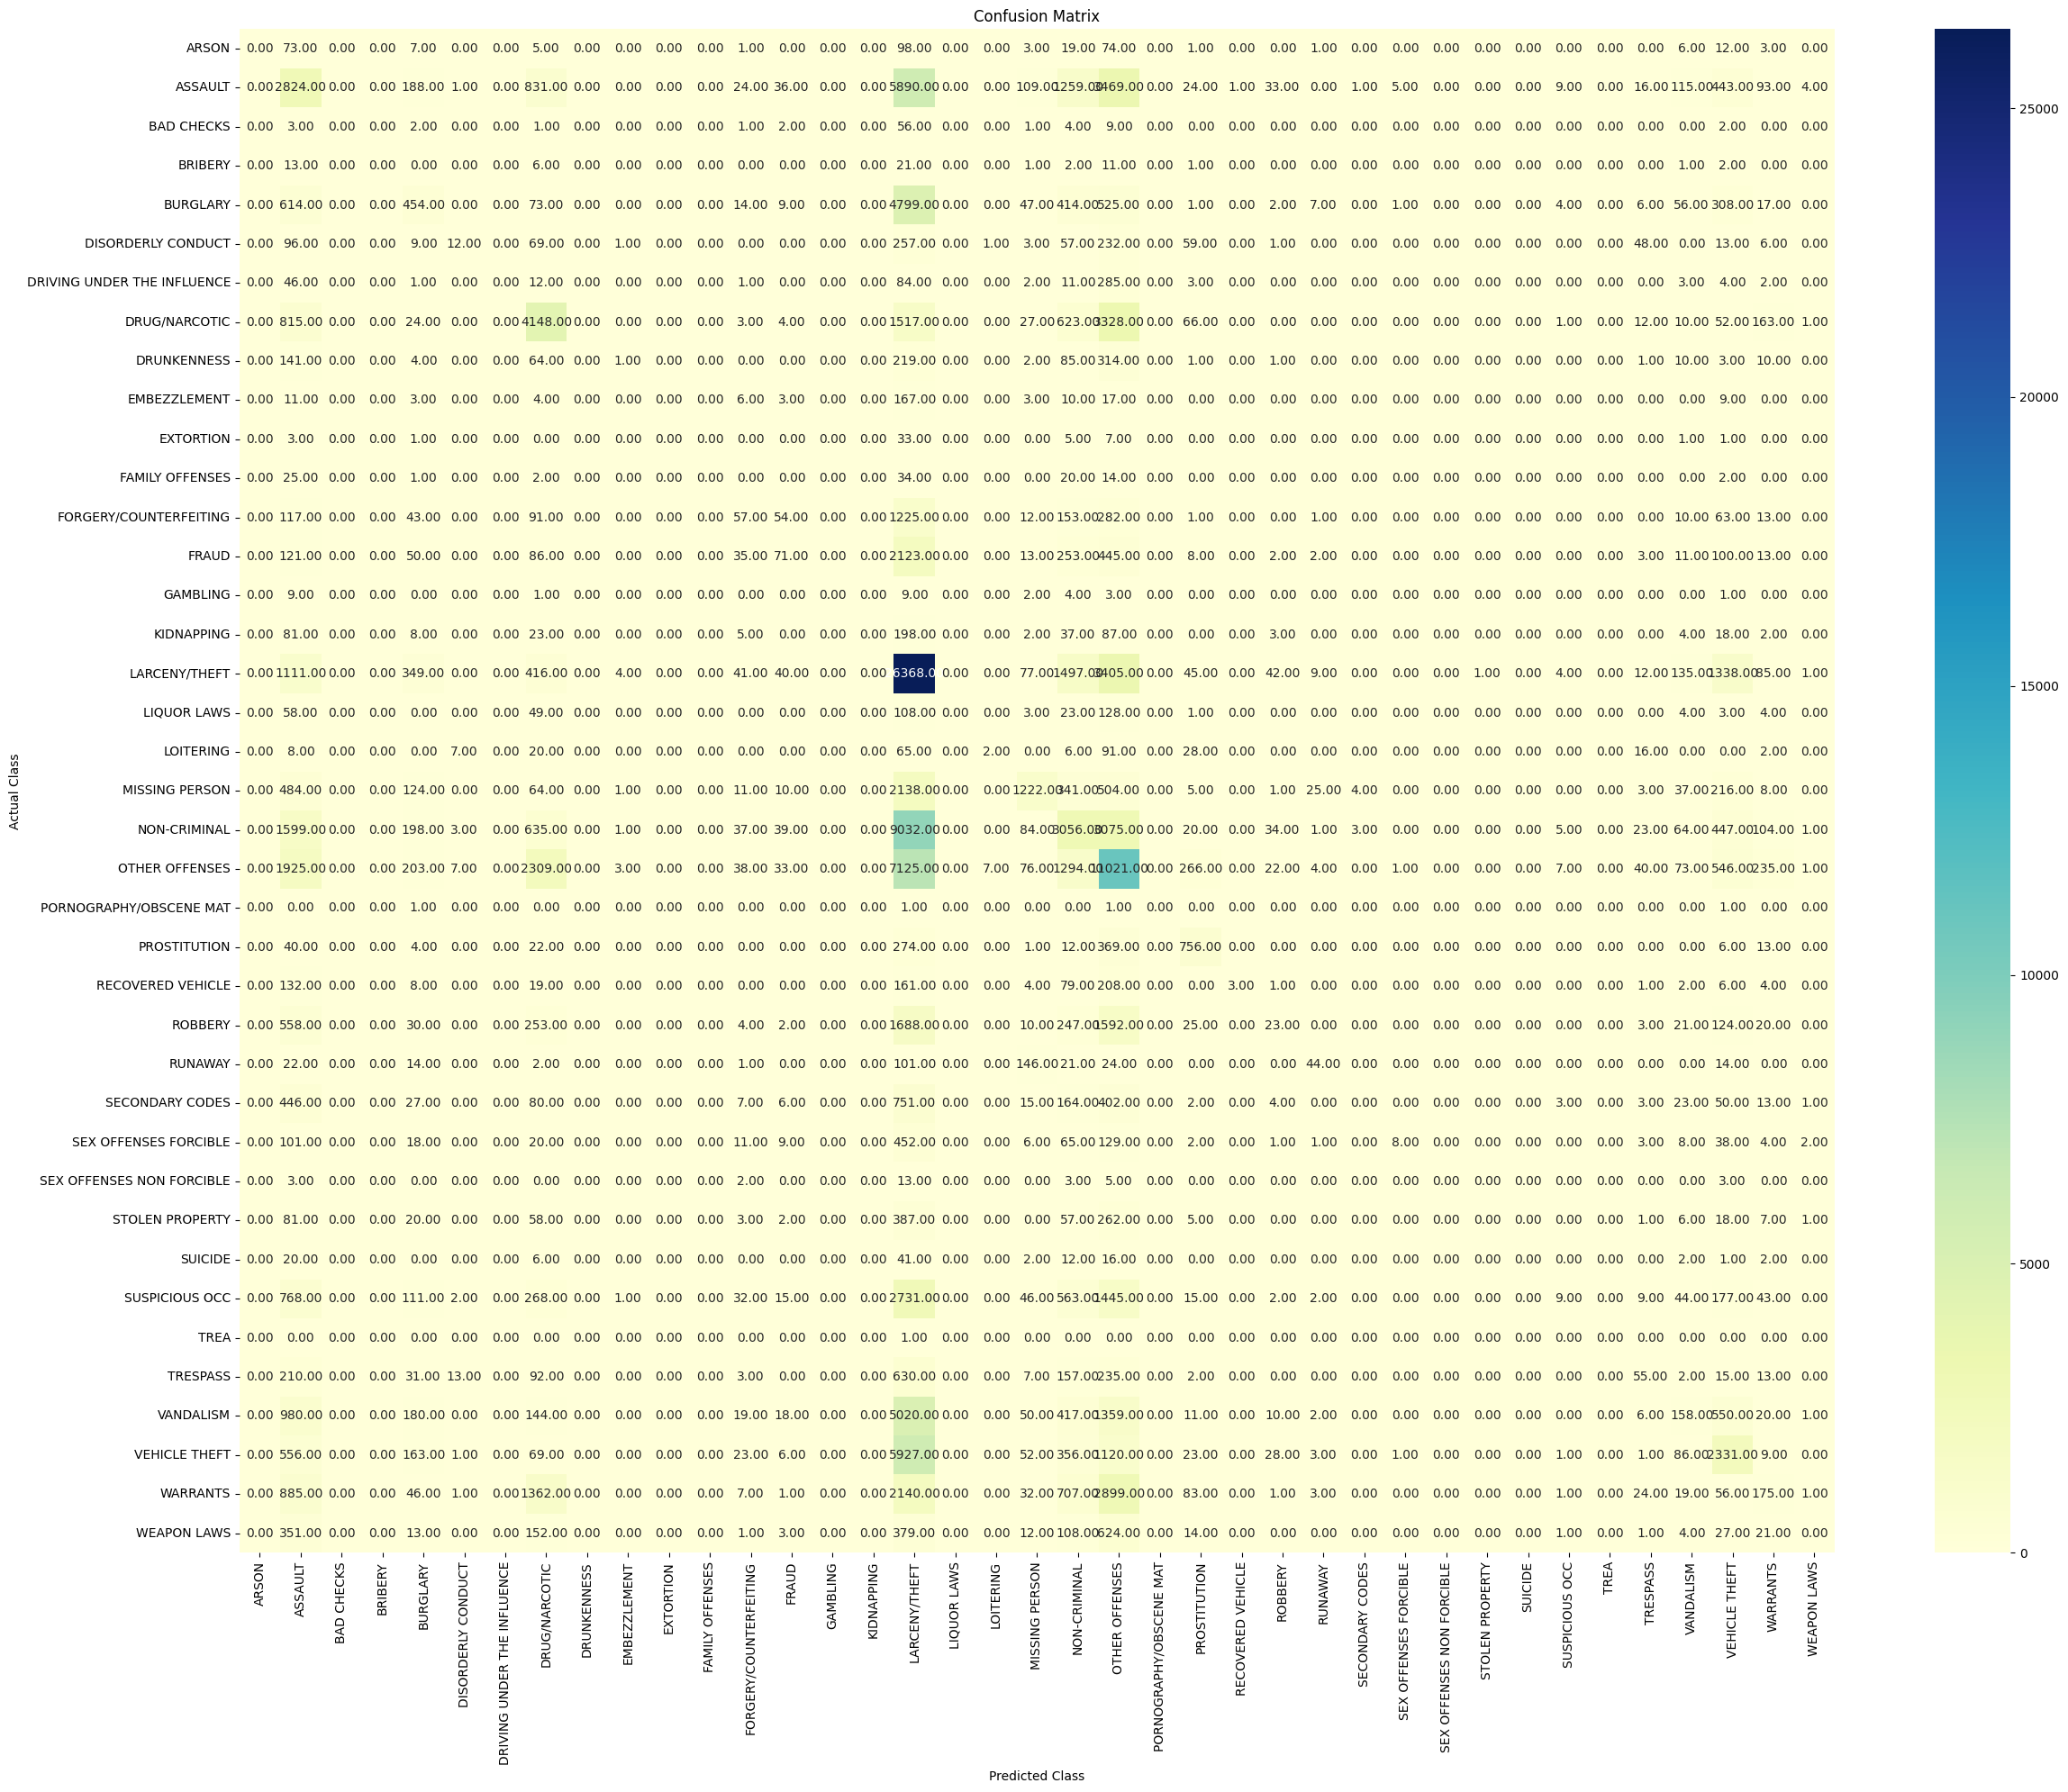

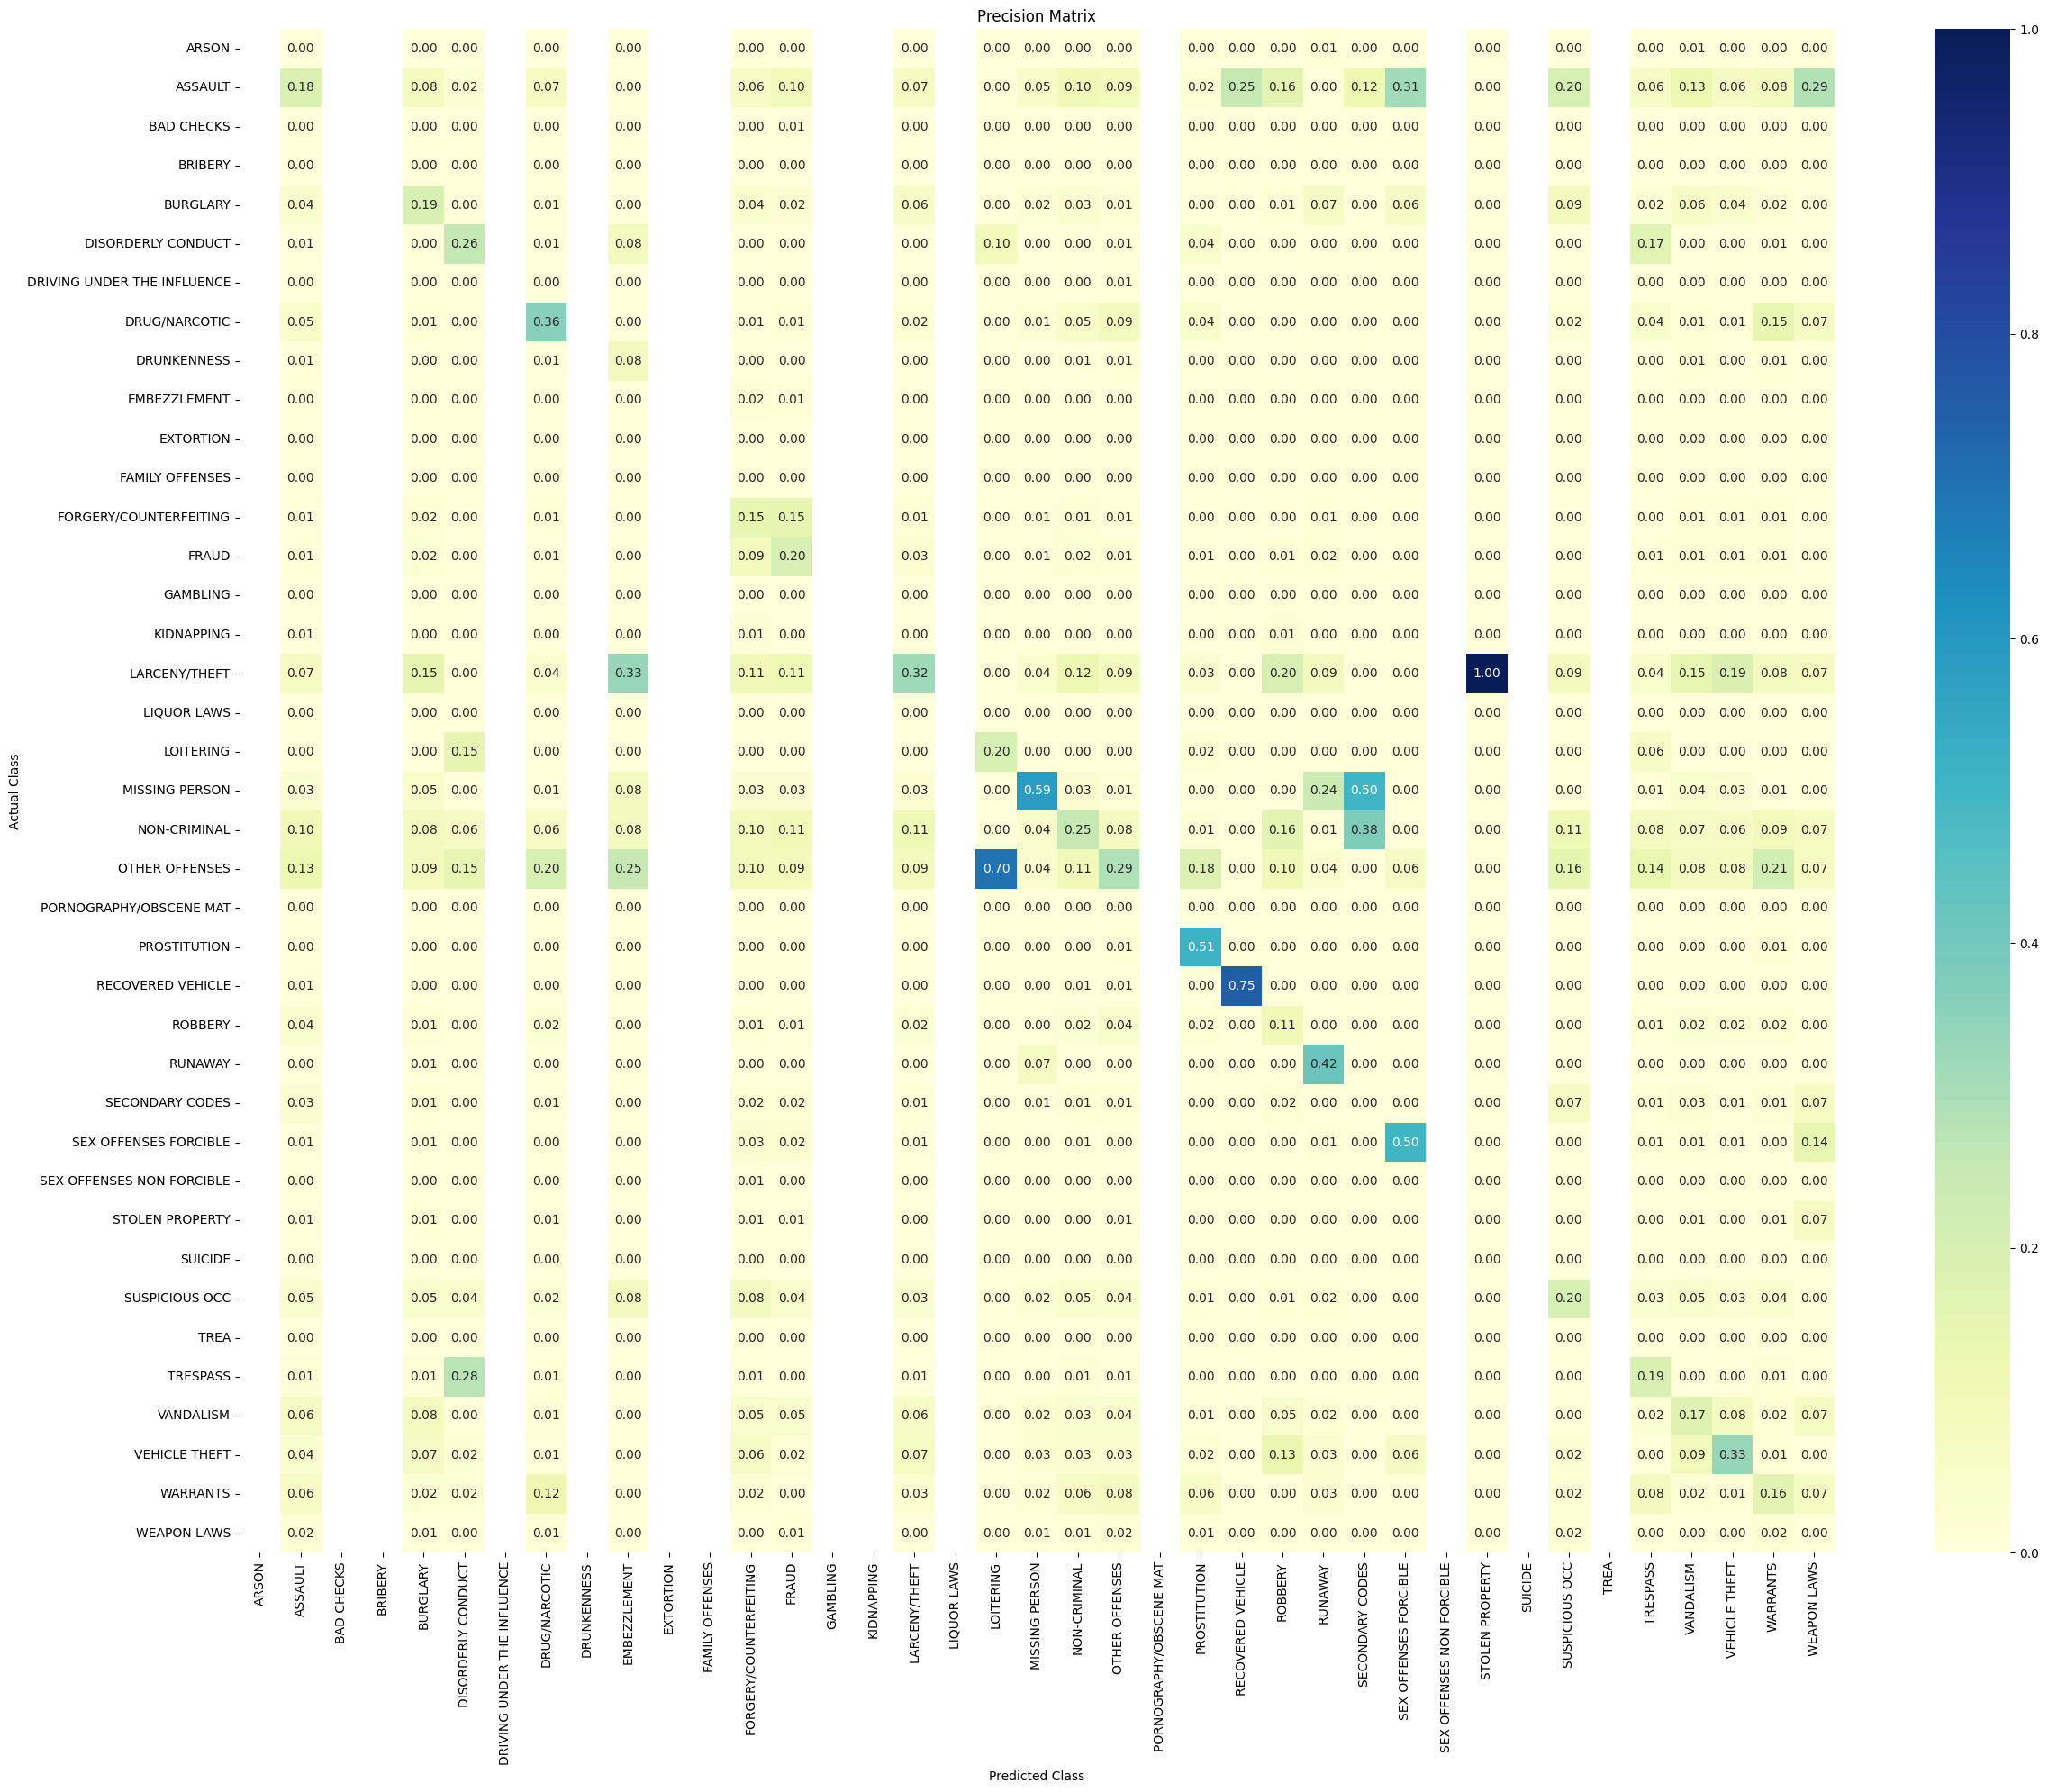

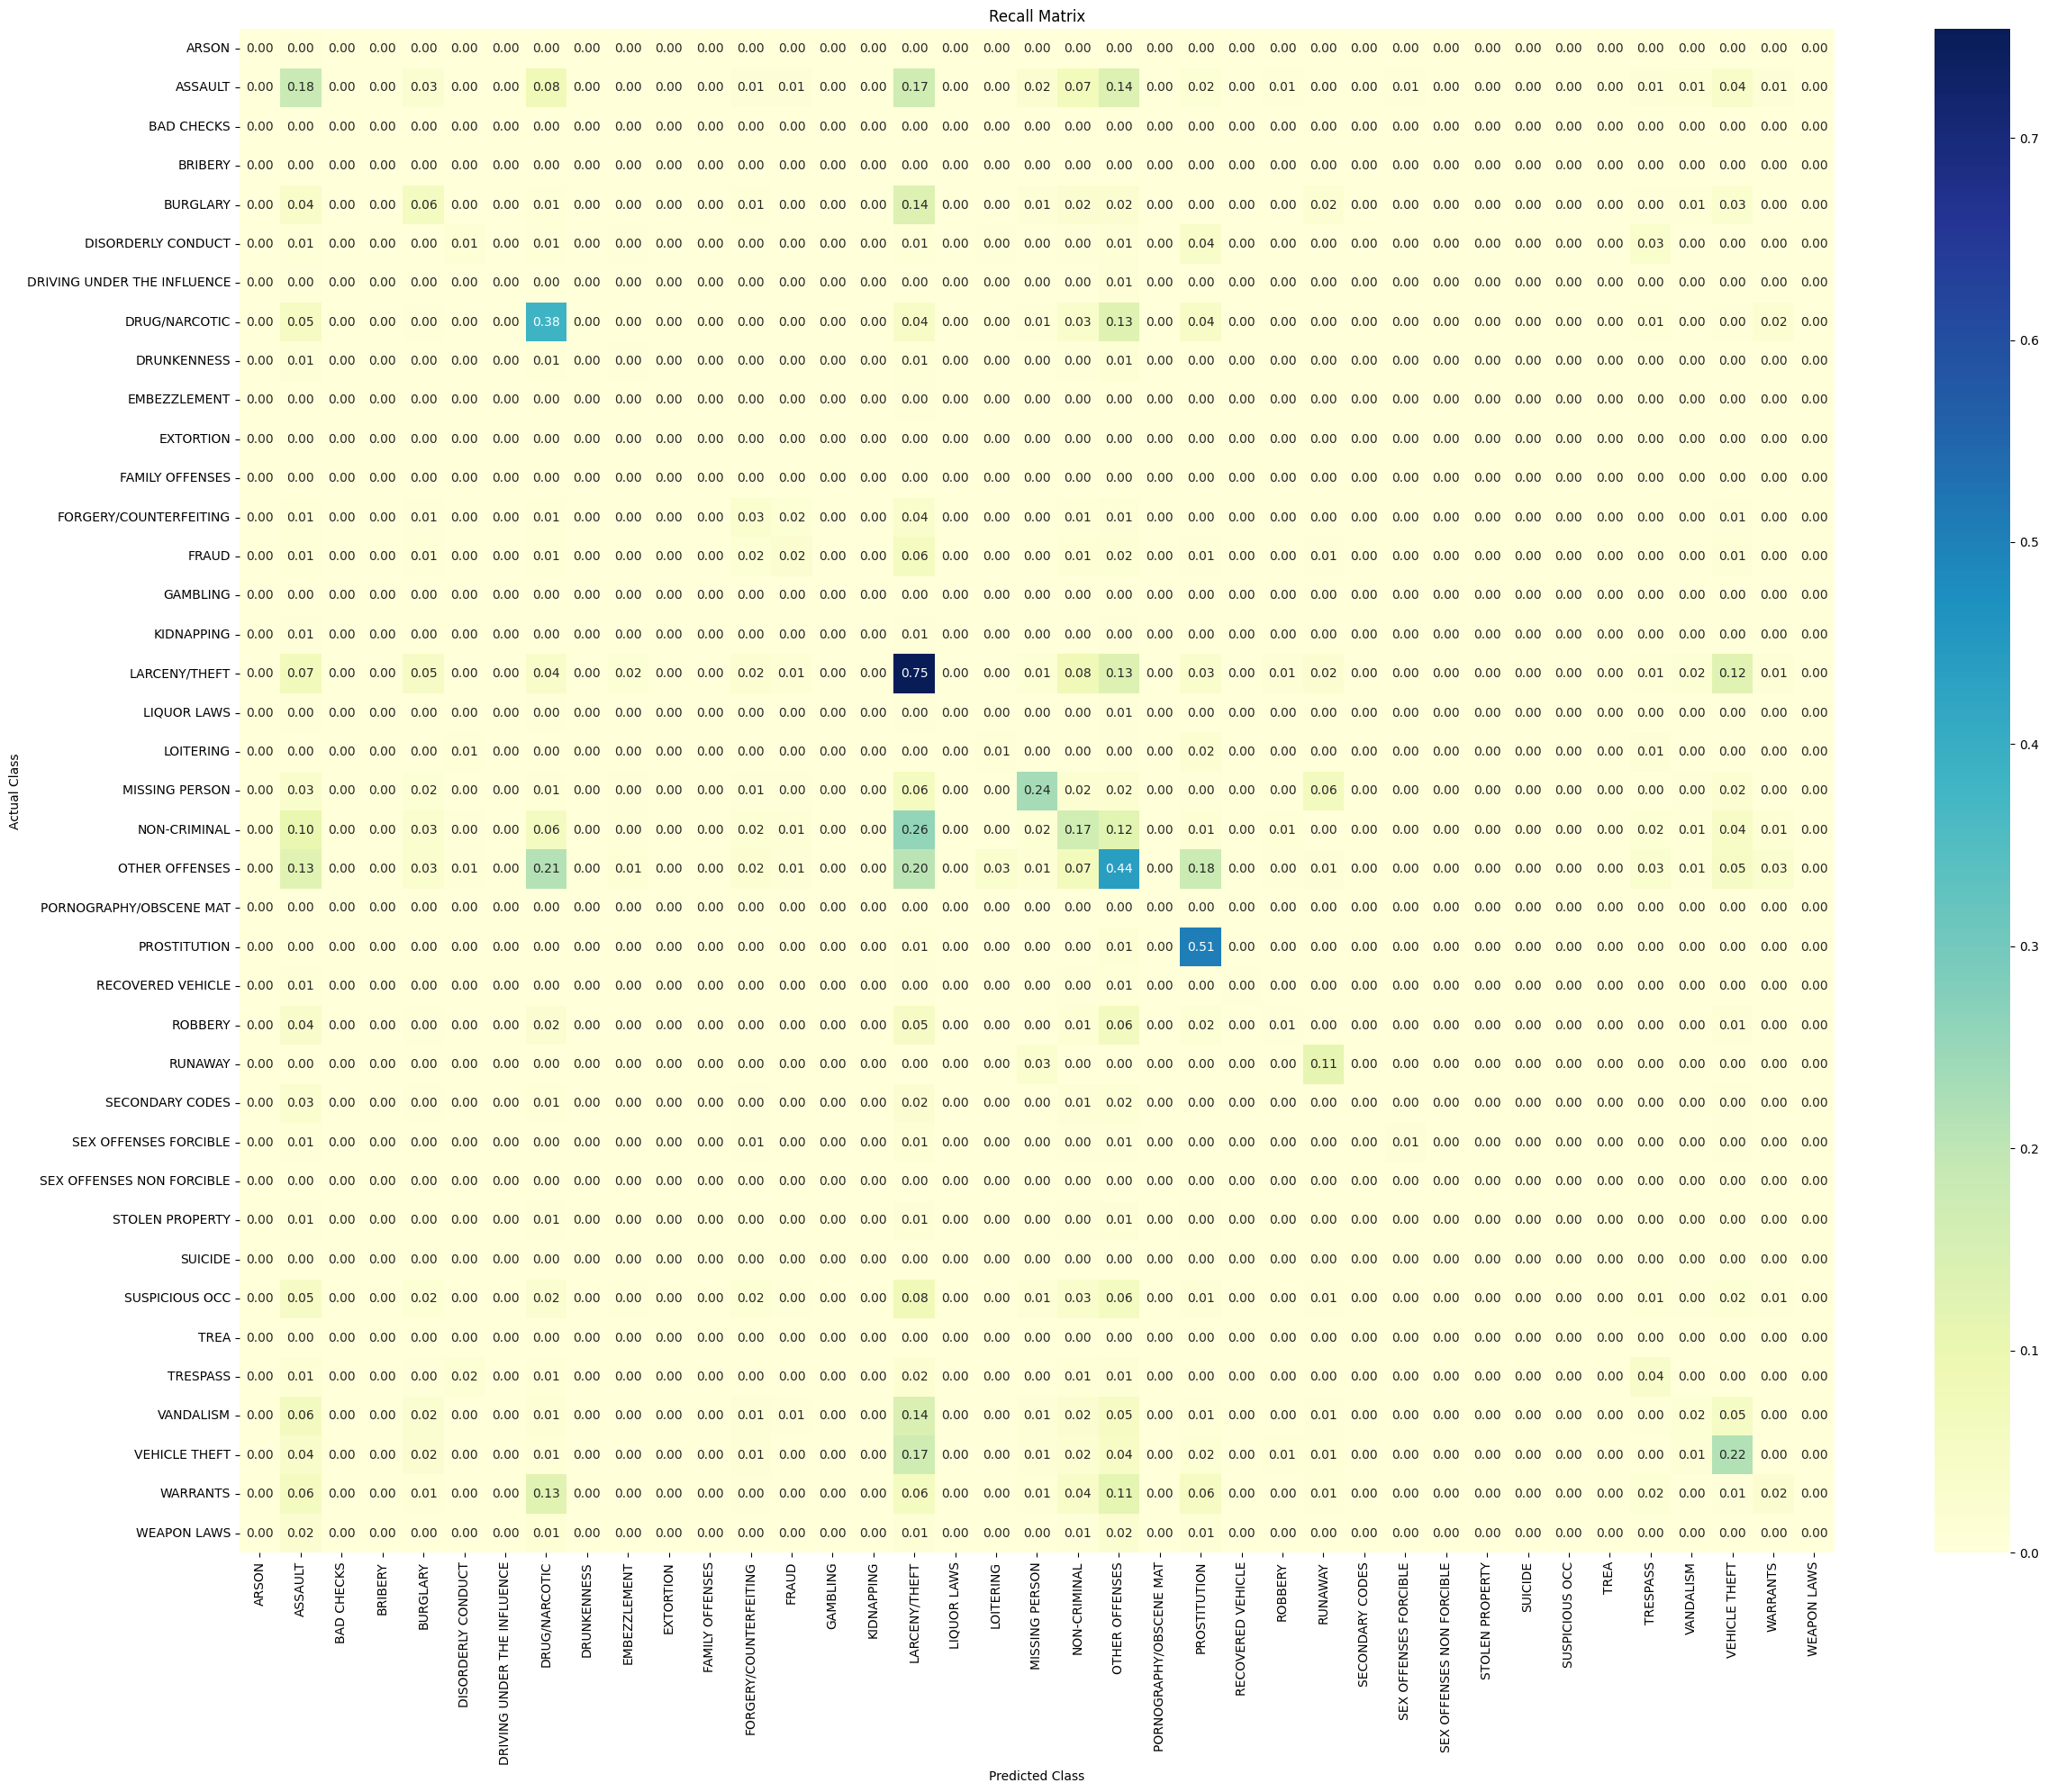

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.18      0.18      0.18     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.19      0.06      0.09      7351
         DISORDERLY CONDUCT       0.26      0.01      0.03       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.36      0.38      0.37     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.15      0.03      0.05      2122
                      FRAUD      

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
dt_train_loss, dt_valid_loss, dt_test_loss = decision_tree_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
def random_forest_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = 'models/'
    model_name = 'random_forest_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = RandomForestClassifier(max_depth=8, n_estimators=100)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)

        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)

    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Training Log Loss: 2.394394114431819
Validation Log Loss: 2.4089308159587746
Testing Log Loss: 2.411654682080375


C:\Users\Monster\AppData\Local\Temp\ipykernel_19632\91422066.py:16: RuntimeWarning: invalid value encountered in divide
  pmat = cmat / cmat.sum(axis=0)


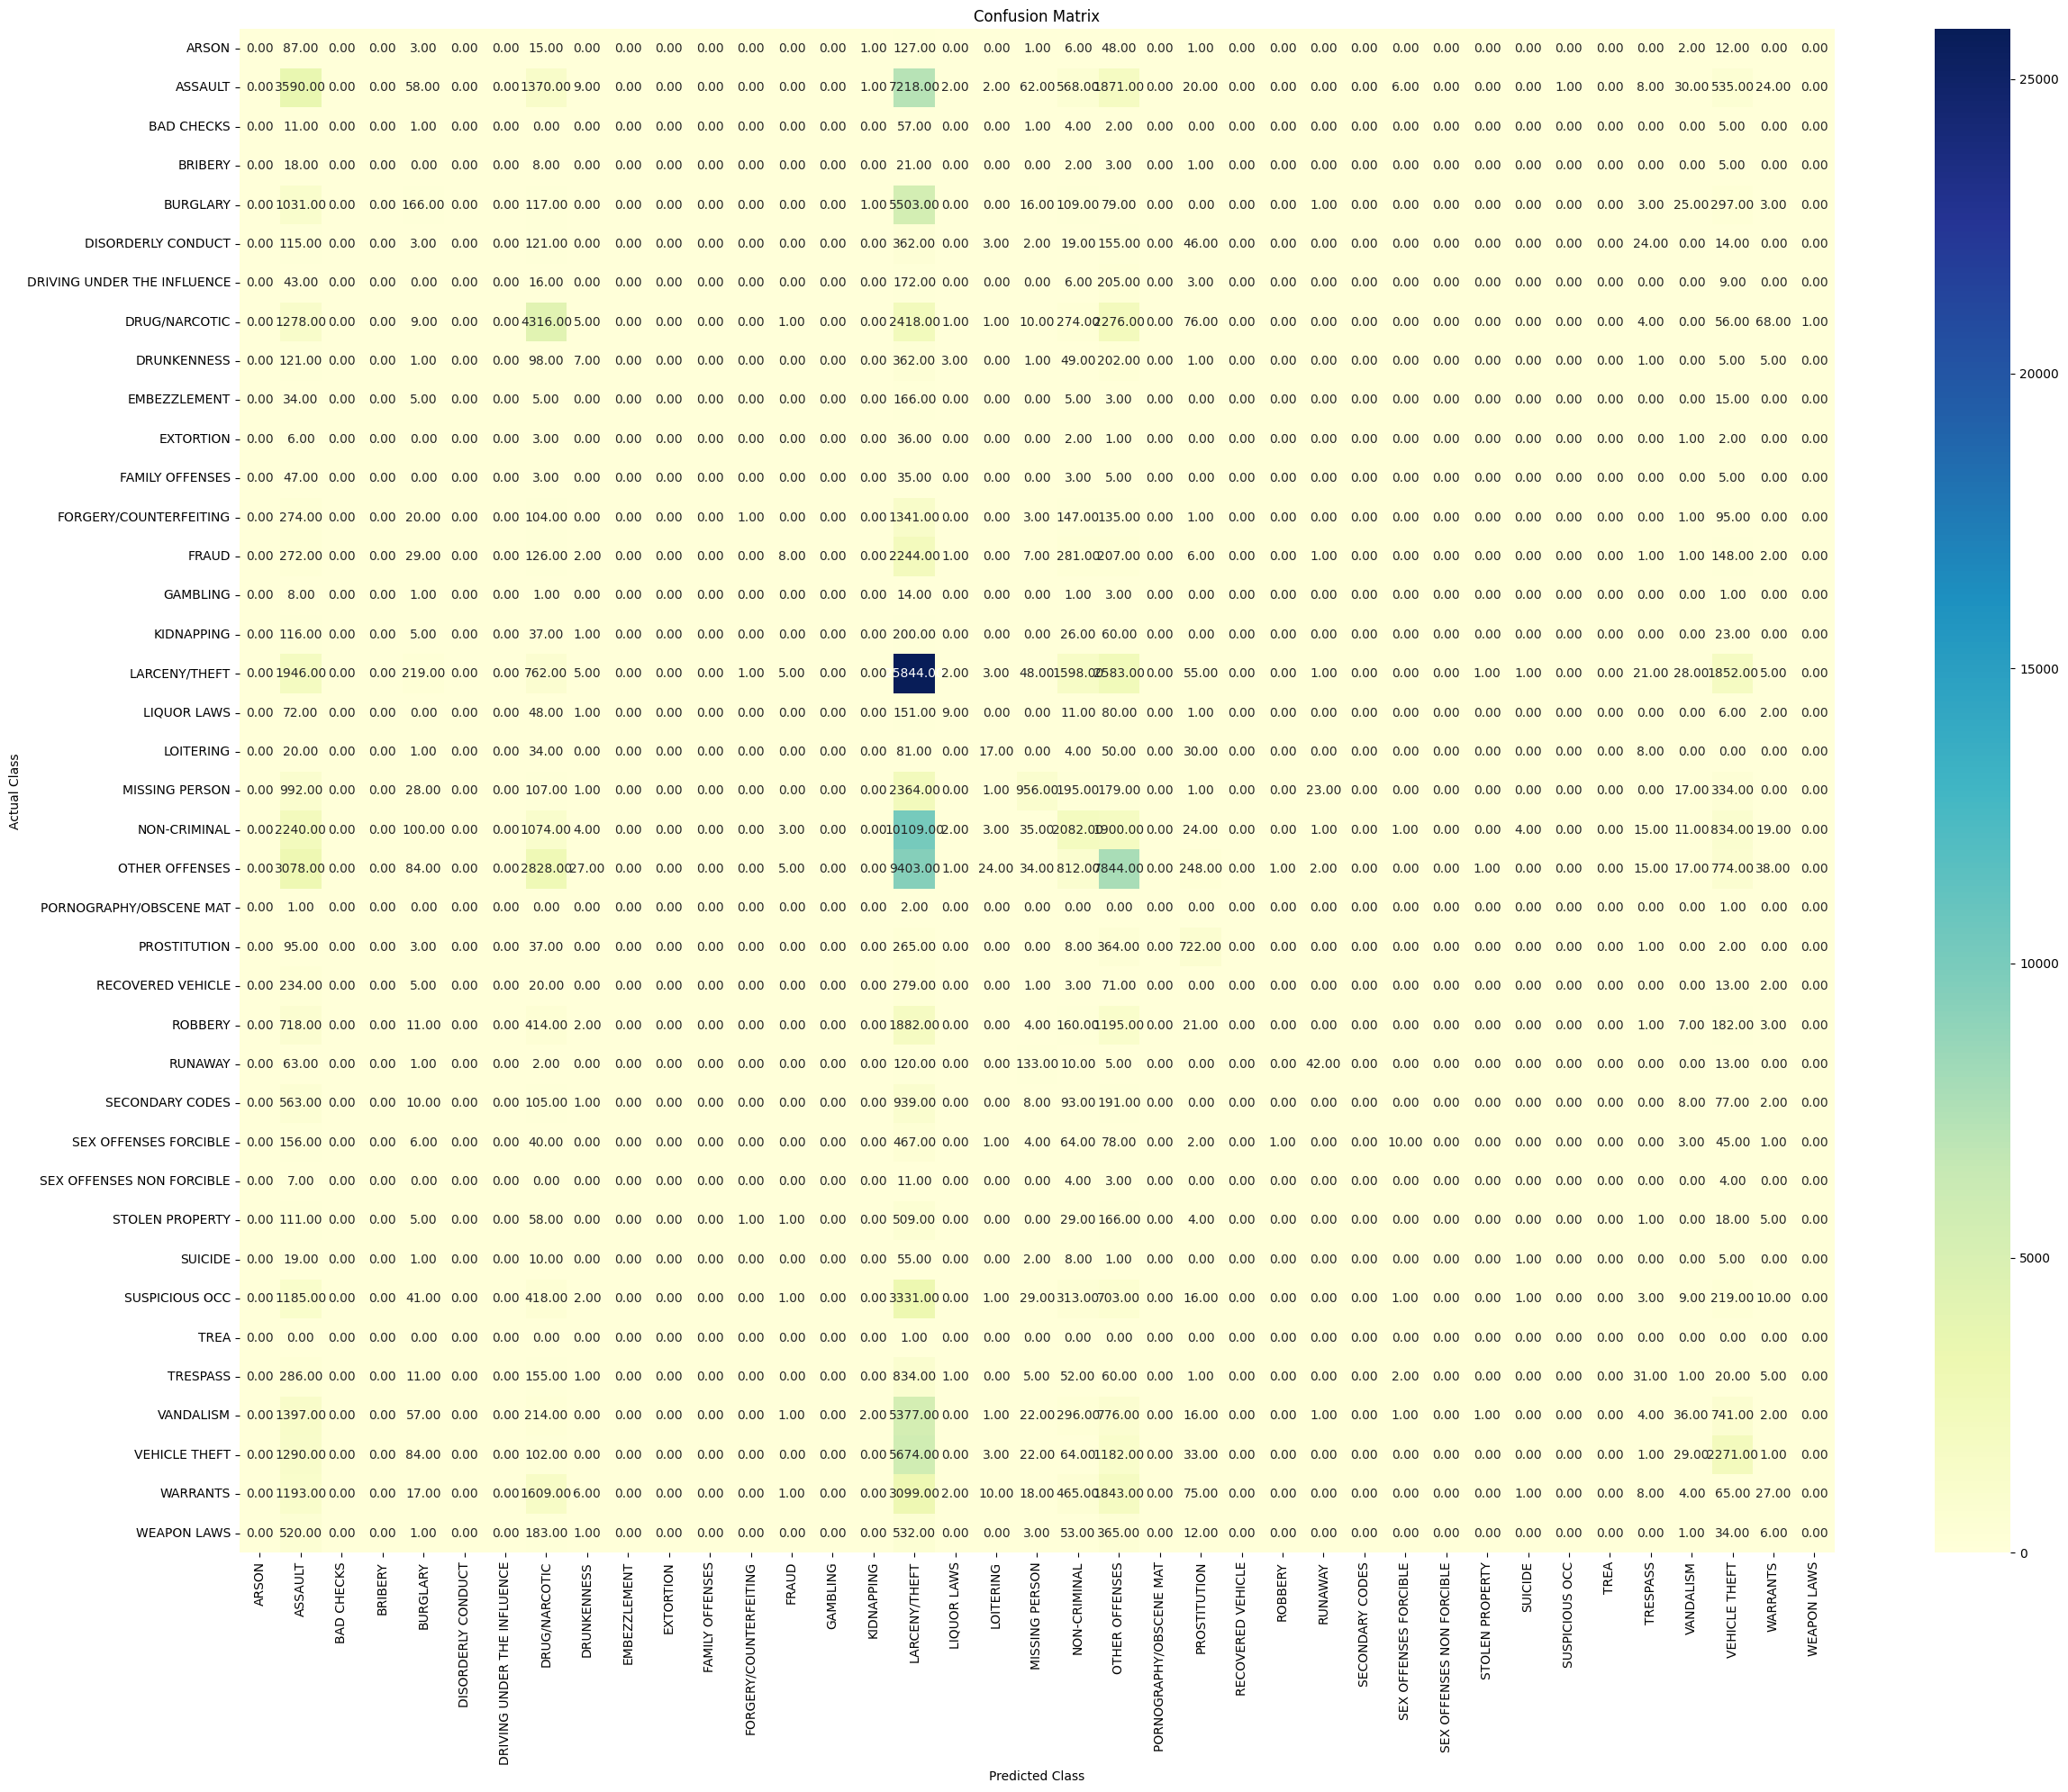

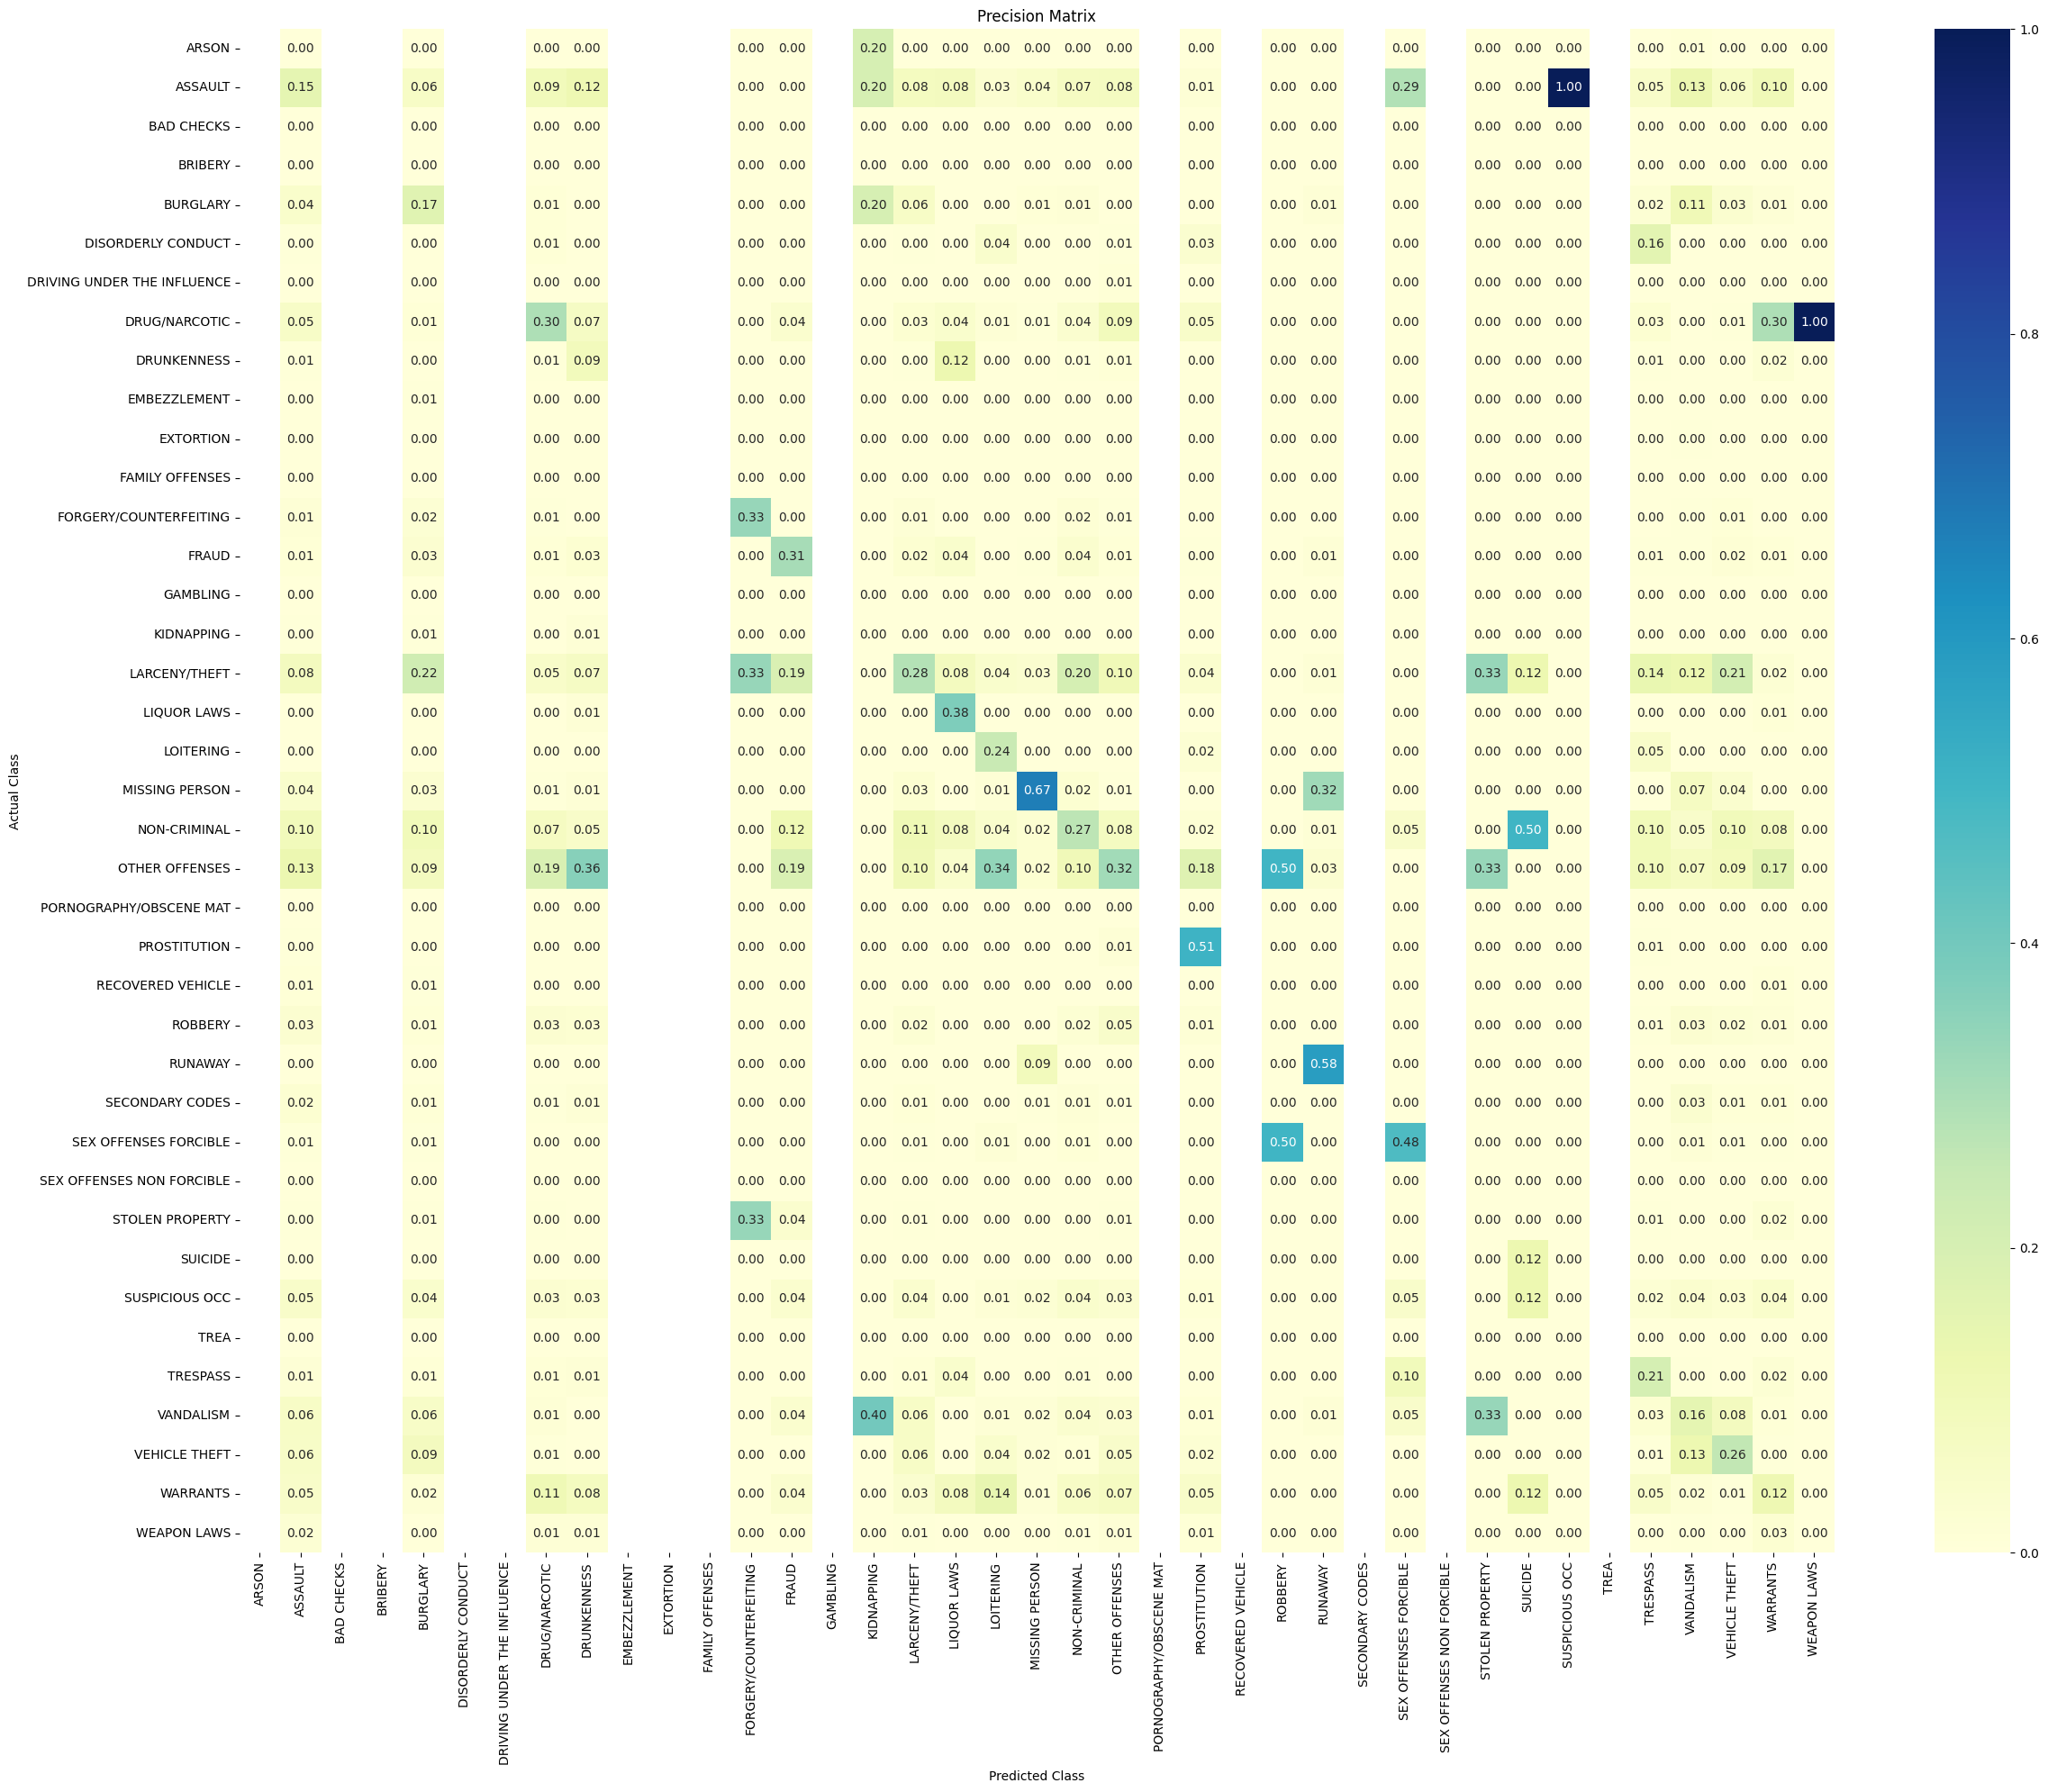

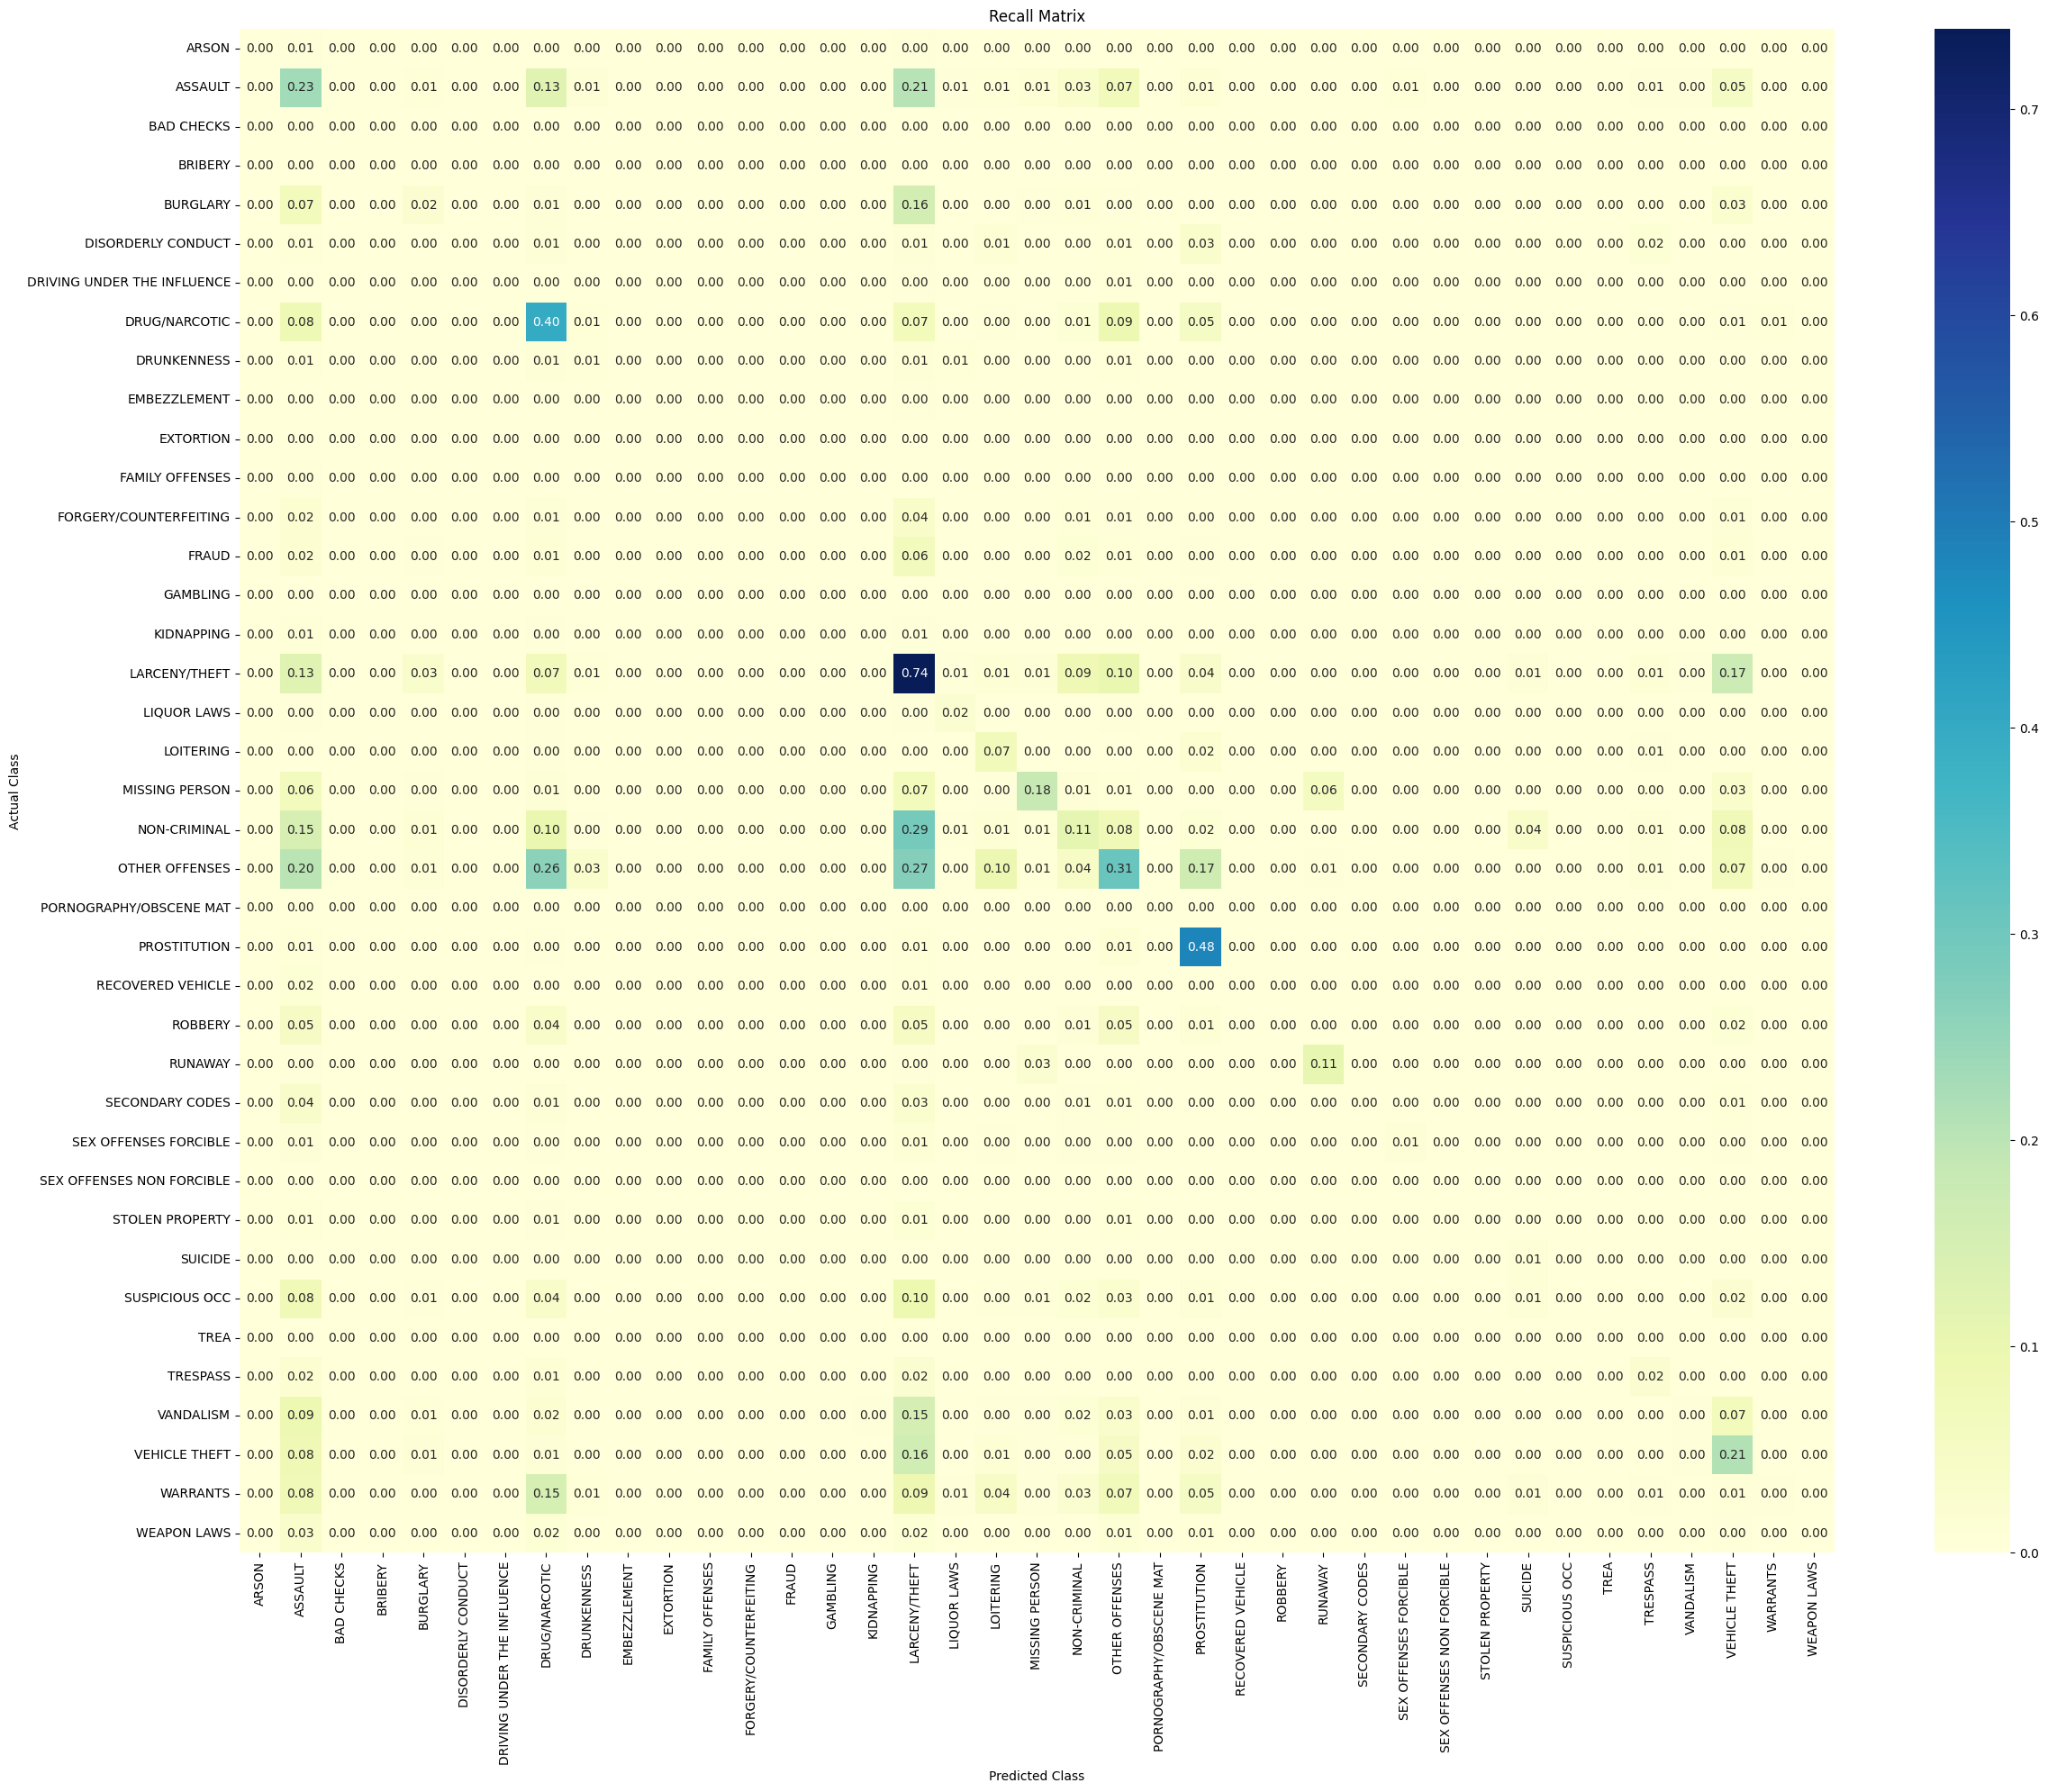

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.15      0.23      0.19     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.17      0.02      0.04      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.30      0.40      0.34     10794
                DRUNKENNESS       0.09      0.01      0.02       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.33      0.00      0.00      2122
                      FRAUD      

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
rf_train_loss, rf_valid_loss, rf_test_loss = random_forest_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### Summary

In [24]:
from tabulate import tabulate

In [25]:
model_names = ['Logistic Regression', 'Decision Tree', 'RandomForest']
train_losses = [lr_train_loss, dt_train_loss, rf_train_loss]
valid_losses = [lr_valid_loss, dt_valid_loss, rf_valid_loss]
test_losses = [lr_test_loss, dt_test_loss, rf_test_loss]

summary_df = pd.DataFrame()
summary_df['Models'] = model_names
summary_df['Train Loss'] = train_losses
summary_df['Valid Loss'] = valid_losses
summary_df['Test Loss'] = test_losses

summary = tabulate(tabular_data=summary_df, headers='keys', tablefmt='psql')
print(summary)

+----+---------------------+--------------+--------------+-------------+
|    | Models              |   Train Loss |   Valid Loss |   Test Loss |
|----+---------------------+--------------+--------------+-------------|
|  0 | Logistic Regression |      2.49047 |      2.49116 |     2.49349 |
|  1 | Decision Tree       |      2.31844 |      2.37711 |     2.37867 |
|  2 | RandomForest        |      2.39439 |      2.40893 |     2.41165 |
+----+---------------------+--------------+--------------+-------------+
